In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
DATA_RAW_PATH = "../data/RAW/RT-BENE.zip" 
DATA_INTER_PATH = "/opt/data/Ubuntu/projects/RT-BENE/data/intermediate"
DATA_PATH = f"{DATA_INTER_PATH}/RT-BENE"
if not os.path.exists(DATA_PATH):
    !unzip -q $DATA_RAW_PATH -d $DATA_INTER_PATH

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [5]:
data = pd.read_csv(f"{DATA_PATH}/blinks.csv")
data

,blink_id,left_eye,right_eye,video,blink
0,0,0_left_000001_rgb.png,0_right_000001_rgb.png,0,0
1,1,0_left_000002_rgb.png,0_right_000002_rgb.png,0,0
2,2,0_left_000003_rgb.png,0_right_000003_rgb.png,0,0
3,3,0_left_000004_rgb.png,0_right_000004_rgb.png,0,0
4,4,0_left_000005_rgb.png,0_right_000005_rgb.png,0,0
...,...,...,...,...,...
107345,107345,16_left_009059_rgb.png,16_right_009059_rgb.png,16,0
107346,107346,16_left_009060_rgb.png,16_right_009060_rgb.png,16,0
107347,107347,16_left_009061_rgb.png,16_right_009061_rgb.png,16,0
107348,107348,16_left_009062_rgb.png,16_right_009062_rgb.png,16,0


### How many videos do we have?

In [6]:
video_ids = np.unique(data["video"])
video_ids

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

### Total images

In [7]:
data["blink_id"].count()

107350

### How many images per video?

In [8]:
data_per_video = data.groupby(by=["video"]).count()
blinks_per_video = data.loc[data["blink"] == 1].groupby(by="video").count()
blinks_per_video = blinks_per_video.div(data_per_video, level="video") * 100
data_per_video = pd.concat([data_per_video["blink_id"], blinks_per_video["blink"]], axis=1, keys=["Images in video","% blink frames"])
data_per_video

,Images in video,% blink frames
video,,
0,12865,7.236689
1,8671,1.476185
2,8702,9.066881
3,3205,5.210608
4,4750,2.736842
5,5355,2.054155
7,1857,8.023694
8,6108,7.514735
9,4210,1.068884


Previous data shows that a rebalancing method will have to be used

#### Split train and test sets

In [9]:
test_size = 0.2
val_size = 0.2
train_data = data.sample(frac=1).reset_index(drop=True)
test_data = train_data[int(train_data.shape[0]*(1-test_size)):]
train_data = train_data[:int(train_data.shape[0]*(1-test_size)) -1]

val_data = train_data[int(train_data.shape[0]*(1-val_size)):]
train_data = train_data[:int(train_data.shape[0]*(1-val_size)) -1]

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(68702, 5)
(17176, 5)
(21470, 5)


#### Generic generator class

In [10]:
import cv2
class RTBeneDataset:
    def __init__(self, phase: str, data: pd.DataFrame, mean: float, std: float, transforms = None):
        self.phase = phase
        self.data = data
        self.mean = mean
        self.std = std
        self.transforms = transforms
        self.counter = 0
        
        if self.phase == "train":
            #Shuffle the data
            self.data = self.data.sample(frac=1).reset_index(drop=True)
        else:
            self.data = self.data.reset_index(drop=True)
            
            
    def __getitem(self, idx):
        row = self.data.loc[idx,["left_eye", "right_eye"]].to_list(), self.data.loc[idx,["blink"]].to_list()[0]
        return row
    
    def __call__(self):
        for i in range(self.data.shape[0]):
            yield self.__getitem(i)
            self.counter +=1
            
            if self.counter == (self.data.shape[0] -1):
                # When all the dataset is readed, reshuffle again
                self.data = self.data.sample(frac=1).reset_index(drop=True)
    
    @staticmethod
    @tf.function
    def tf_load_row(x, y):
        image_l = tf.io.read_file(tf.strings.join([f"{DATA_PATH}/images/", x[0]]))
        image_r = tf.io.read_file(tf.strings.join([f"{DATA_PATH}/images/", x[1]]))
        image_l = tf.image.decode_png(image_l, channels=3)
        image_r = tf.image.decode_png(image_r, channels=3)
        y = tf.cast(y, tf.float32)
        return (image_l, image_r), [tf.abs(1-y), y]
    
def set_shapes(imgs, label, img_shape=(36,60,3)):
        imgs[0].set_shape(img_shape)
        imgs[1].set_shape(img_shape)
        label.set_shape([])
        return imgs, label

## Resampling to get better distribution of the data

In [11]:
train_blink_RTB = RTBeneDataset("train", train_data.loc[train_data["blink"] == 1], 127.5, 1)
train_no_blink_RTB = RTBeneDataset("train", train_data.loc[train_data["blink"] == 0], 127.5, 1)
val_RTB = RTBeneDataset("val", val_data, 127.5, 1)
test_RTB = RTBeneDataset("val", test_data, 127.5, 1)

### Data augmentation

In [12]:
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)

In [13]:
transforms = Compose([
            Rotate(limit=20),
            RandomBrightness(limit=0.2),
            JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip(),
        ])

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    return aug_img

def scale(image, label):
    return (tf.cast(image[0], tf.float32)/255.0, tf.cast(image[1], tf.float32)/255.0), label

def process_data(image, label):
    aug_img_l = tf.numpy_function(func=aug_fn, inp=[image[0]], Tout=tf.uint8)
    aug_img_r = tf.numpy_function(func=aug_fn, inp=[image[1]], Tout=tf.uint8)
    return (aug_img_l, aug_img_r), label

/home/esteve/.local/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/esteve/.local/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(
/home/esteve/.local/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [14]:
batch_size = 256

blink_dataset = tf.data.Dataset.from_generator(train_blink_RTB, 
                                               output_types=(tf.string, tf.float32), 
                                               output_shapes=((2),()))

no_blink_dataset = tf.data.Dataset.from_generator(train_no_blink_RTB, 
                                                  output_types=(tf.string, tf.float32), 
                                                  output_shapes=((2),()))

train_dataset  = tf.data.Dataset.sample_from_datasets([blink_dataset, no_blink_dataset], [0.4, 0.6], stop_on_empty_dataset=True)\
    .map(RTBeneDataset.tf_load_row, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(process_data, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(scale, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(batch_size)\
    .repeat()


val_dataset = tf.data.Dataset.from_generator(val_RTB, 
                                               output_types=(tf.string, tf.float32), 
                                               output_shapes=((2),()))\
    .map(RTBeneDataset.tf_load_row, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(scale, num_parallel_calls=tf.data.AUTOTUNE)\
    .prefetch(tf.data.AUTOTUNE)\
    .batch(batch_size)

test_dataset = tf.data.Dataset.from_generator(test_RTB, 
                                               output_types=(tf.string, tf.float32), 
                                               output_shapes=((2),()))\
    .map(RTBeneDataset.tf_load_row, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(scale, num_parallel_calls=tf.data.AUTOTUNE)\
    .prefetch(tf.data.AUTOTUNE)\
    .batch(batch_size)

2022-02-13 20:09:01.733033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 20:09:01.825211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 20:09:01.825515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 20:09:01.826135: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Test image augmentations

In [15]:
it = train_dataset.as_numpy_iterator()

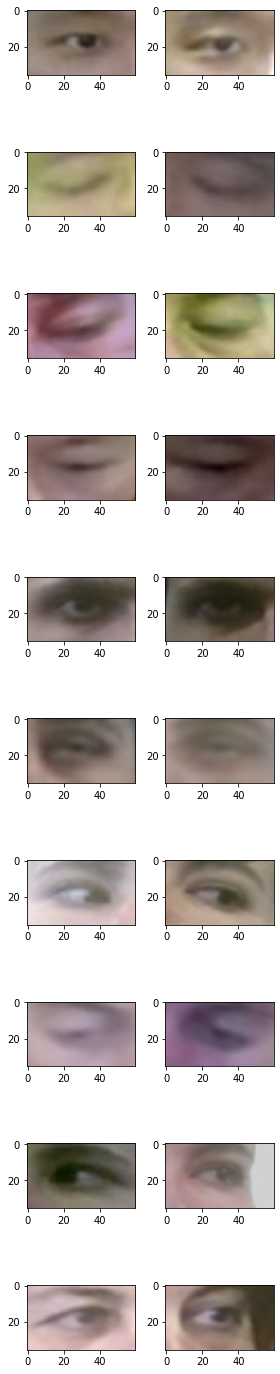

In [17]:
for data in it:
    #print(data[1])
    fig,axs = plt.subplots(10,2, figsize=(4,20))
    for i in range(10):
        axs[i,0].imshow(data[0][0][i])
        axs[i,1].imshow(data[0][1][i])
    fig.tight_layout()
    break

### Create model

In [18]:
from tensorflow import keras
from tensorflow.keras import regularizers, initializers, layers
from tensorflow.keras.applications import DenseNet121

In [19]:
left_eye = keras.Input(shape=(36, 60, 3))
right_eye = keras.Input(shape=(36, 60, 3))
featext_left = DenseNet121(weights="imagenet", include_top=False, input_shape=(36, 60, 3))
featext_left._name = "featext_left"
for layer in featext_left.layers:
    layer.kernel_regularizer=regularizers.l1(1e-3),
featext_right = DenseNet121(weights="imagenet", include_top=False, input_shape=(36, 60, 3))
featext_right._name = "featext_right"
for layer in featext_right.layers:
    layer.kernel_regularizer=regularizers.l1(1e-3),
left_feat_extractor = featext_left(left_eye)
right_feat_extractor = featext_right(right_eye)
concat = layers.Concatenate()([left_feat_extractor, right_feat_extractor])
flat = layers.Flatten()(concat)
dense_1 = layers.Dense(256, activation="relu",
                      kernel_regularizer=regularizers.l2(1e-5),
                       kernel_initializer=initializers.GlorotNormal)(flat)
do_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(128, activation="relu",
                      kernel_regularizer=regularizers.l2(1e-5),
                       kernel_initializer=initializers.GlorotNormal)(do_1)
do_2 = layers.Dropout(0.2)(dense_2)
out = layers.Dense(2, activation="softmax")(do_2)

model = keras.Model(inputs=([left_eye, right_eye]), outputs=out, name="densenet_all_data_rebalanced_aug_dropout")
model.summary()

Model: "densenet_all_data_rebalanced_aug_dropout"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 60, 3)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 36, 60, 3)]  0           []                               
                                                                                                  
 featext_left (Functional)      (None, 1, 1, 1024)   7037504     ['input_1[0][0]']                
                                                                                                  
 featext_right (Functional)     (None, 1, 1, 1024)   7037504     ['input_2[0][0]']                
                                                           

In [20]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              loss=keras.losses.CategoricalCrossentropy(), 
              metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall(), F1_score])

In [21]:
from datetime import datetime

run_id = f'{model.name}-{datetime.now().strftime("%m-%H%M%S")}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"models/{run_id}/" + "{epoch:02d}-{val_F1_score:.2f}",
    save_weights_only=True,
    monitor='val_F1_score',
    mode='max',
    save_best_only=False)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{run_id}", update_freq=100,)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5)

history = model.fit(train_dataset, 
          validation_data=val_dataset, 
          epochs=40, 
          steps_per_epoch=int(train_data.shape[0]/(2*batch_size)), 
          validation_steps=int(val_data.shape[0]/batch_size),
          callbacks=[model_checkpoint_callback, tensorboard_callback, reduce_lr_callback])

Epoch 1/40


2022-02-06 16:56:49.902876: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2022-02-06 16:56:51.517747: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-06 16:56:55.352128: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


134/134 [==============================] - 100s 575ms/step - loss: 0.1430 - accuracy: 0.0050 - precision: 0.9458 - recall: 0.9458 - F1_score: 0.9460 - val_loss: 3.1240 - val_accuracy: 0.0205 - val_precision: 0.6792 - val_recall: 0.6792 - val_F1_score: 0.6792 - lr: 0.0010
Epoch 2/40
134/134 [==============================] - 79s 594ms/step - loss: 0.0686 - accuracy: 0.0167 - precision: 0.9779 - recall: 0.9779 - F1_score: 0.9776 - val_loss: 0.5844 - val_accuracy: 0.1583 - val_precision: 0.8812 - val_recall: 0.8812 - val_F1_score: 0.8812 - lr: 0.0010
Epoch 3/40
134/134 [==============================] - 76s 570ms/step - loss: 0.0519 - accuracy: 0.0310 - precision: 0.9837 - recall: 0.9837 - F1_score: 0.9839 - val_loss: 0.0364 - val_accuracy: 0.0968 - val_precision: 0.9879 - val_recall: 0.9879 - val_F1_score: 0.9879 - lr: 0.0010
Epoch 4/40
134/134 [==============================] - 74s 556ms/step - loss: 0.0466 - accuracy: 0.0349 - precision: 0.9840 - recall: 0.9840 - F1_score: 0.9843 - val

KeyboardInterrupt: 

In [21]:
model.load_weights("models/densenet_all_data_rebalanced_aug_dropout-02-165635/26-0.99")

In [22]:
results = model.evaluate(test_dataset)

2022-02-13 20:10:50.384532: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2022-02-13 20:10:51.969706: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-13 20:10:55.708456: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


84/84 [==============================] - 30s 228ms/step - loss: 0.0451 - accuracy: 0.0566 - precision: 0.9925 - recall: 0.9925 - F1_score: 0.9926
